In [1]:
#imports
import numpy as np
import numpy.random as rd
import numpy.linalg as linalg
import math
from scipy.optimize import linprog
import matplotlib.pyplot as plt
from hmmlearn import hmm

In [2]:
def sample(prob): # BS can be done
    r = rd.random();i = 0
    while r > prob[i]:
        r-=prob[i]
        i+=1
    return i

def bernoulli(prob):
    if rd.random() > prob:
        return 1.0
    return 0.0

def row_normalize(arr):
    arr = np.array(arr,float)
    for i in range(np.shape(arr)[0]):
        arr[i] = arr[i]/np.sum(arr[i])
    return arr

def dot(x,y):
    return np.sum(np.multiply(x,y))

def steady_state_prob(matrix):
    """
    This function calculates relative throughput from a probability matrix
    :param matrix: the probability matrix
    :return: A list of relative throughput values
    """
    a_list = []
    b_list = []
    for v in matrix:
        a_list.append(1)
        b_list.append(0)
    b_list.append(1)
    A = np.append(np.transpose(matrix) - np.identity(len(matrix)), [a_list], axis=0)
    b = np.transpose(np.array(b_list))
    return np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

In [14]:
en = 3
ch = 3
P = np.array([[.1, .2, .7],[.5, .3, .2],[.3, .3, .4]])
E = np.array([[.5,.6,.4],[.2,.3,.1],[.4,.5,.3]])
# E = np.array([[.6,.9,.3],[.3,.5,.1],[.4,.1,.05]])
R = np.array([8.,6.,4.])
# P = row_normalize([np.random.rand(ch)/2])[0]
# E = np.random.rand(en,ch)/2
# R = np.array([np.random.randint(1,10) for i in range(en)])
tol = .3
print(P)
print(E)
print(R)

[[0.1 0.2 0.7]
 [0.5 0.3 0.2]
 [0.3 0.3 0.4]]
[[0.5 0.6 0.4]
 [0.2 0.3 0.1]
 [0.4 0.5 0.3]]
[8. 6. 4.]


In [59]:
# example 2
en = 5
ch = 4
# P = np.array([.3,.1,.2,.4])
P = np.array([[.35,.15,.05,.45],[.3,.3,.2,.2],[.3,.4,.1,.2],[.2,.15,.25,.4]])
# P = steady_state_prob(P)
E = np.array([[.4,.6,.4,.3],[.3,.4,.4,.3],[.3,.2,.1,.4],[.1,.35,.3,.4],[.2,.4,.1,.3]])
R = np.array([7.,5.5,4.,6.,5.])
tol = .35
print(P)
print(E)
print(R)

[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[7.  5.5 4.  6.  5. ]


In [60]:
ub = np.sum(E*steady_state_prob(P),axis=1)
ltemp = linprog(c = -1*R, A_ub = [ub], b_ub = [tol],A_eq = np.ones((1,en)),b_eq = [1.0],method='simplex')
print(min(ub))
print(dot(ltemp.x,R), np.sum(ltemp.x),ltemp.con, ltemp.success, dot(ltemp.x,ub))
org_x = ltemp.x
print(ltemp.x)

0.262507237984945
6.50100842330051 1.0 [0.] True 0.35
[0.50100842 0.         0.         0.49899158 0.        ]


In [61]:
print(en,ch,tol,np.dot(ltemp.x,R),min(ub))
print(P)
print(E)
print(ltemp.x)

5 4 0.35 6.50100842330051 0.262507237984945
[[0.35 0.15 0.05 0.45]
 [0.3  0.3  0.2  0.2 ]
 [0.3  0.4  0.1  0.2 ]
 [0.2  0.15 0.25 0.4 ]]
[[0.4  0.6  0.4  0.3 ]
 [0.3  0.4  0.4  0.3 ]
 [0.3  0.2  0.1  0.4 ]
 [0.1  0.35 0.3  0.4 ]
 [0.2  0.4  0.1  0.3 ]]
[0.50100842 0.         0.         0.49899158 0.        ]


In [62]:
# finding safe x0
ub = E.transpose();tol_arr = [tol]*ch
ltemp = linprog(c=np.zeros(en),A_ub = ub,b_ub=tol_arr,A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-3})
x0 = np.transpose(row_normalize([ltemp.x+(0.0)])) # noise to safe to avoid singular matrices, 1.0e-2 is working
norm_x0 = linalg.norm(x0)
e0 = x0/norm_x0 # safe vector
e0_trans = e0.transpose()
en0 = sample(x0.transpose()[0])
b0 = bernoulli(E[en0][sample(steady_state_prob(P))])
yt = (E[en0]*(1-b0))+((1-E[en0])*b0)
yt = row_normalize([np.exp(yt)]).transpose()
c0 = dot(x0,np.matmul(E,yt)) # safe cost
print(x0.flatten(),c0)

[0.25 0.25 0.5  0.   0.  ] 0.31968671953046024


In [63]:
# parameters
reg = 0.1 # lambda > 0, regualarization param
conf = 0.1 # delta >= 0, <= 1, confidence prob -> with 1-del prob tolerance holds
alfa_c = 0.001 # >= 1, ellipse radii, best : 0.001
Sa = 1.;La = 1.;Ra = 1. # assumption parameters
R_sum = np.sum(R)
Rn_trans = R/R_sum
Rn = np.transpose([Rn_trans])
# x = [np.transpose(row_normalize([np.ones(en)]))]
x = [x0]
r = [dot(x[-1],Rn)];c = [c0]
b = [0]; enc = [rd.randint(en)];chnl = [rd.randint(ch)]
avg_rate = []
# markov extra param
p = []
# p.append(row_normalize(np.random.rand(ch,ch)))
p.append(row_normalize(np.ones((ch,ch))))
step = 50
lr = 0.01
eps = .5
eps_min = 0.01

In [64]:
# algo
iop = np.identity(en) - (np.matmul(x0,x0.transpose())/pow(norm_x0,2.0))
sigopt = reg*iop; uopt = 0.0
rn = rd.rand()
sprob = steady_state_prob(p[-1])
for t in range(1,50000):
    enc.append(sample(x[-1].transpose()[0]))
    if rn < max(eps_min,eps/float(t+1)): # put as running eps
        enc.append(rd.randint(0,en))
    else:
        enc.append(sample(x[-1].transpose()[0]))
    chnl.append(sample(P[chnl[-1]]))
    b.append(int(bernoulli(E[enc[-1]][chnl[-1]])))
    if t%step == 0:
        # markov part
        model = hmm.MultinomialHMM(n_components=ch, params='t', init_params='',n_iter=100, tol=1.0e-2)
        model.startprob_ = sprob
        if rn < max(eps_min,eps/float(t+1)):
            step_emiss = np.sum(E,axis=0)/3
        else:
            step_emiss = np.sum(x[-1]*E,axis=0)
        model.emissionprob_ = [[step_emiss[i],1-step_emiss[i]] for i in range(ch)]
        model.transmat_ = np.copy(p[-1])
        model.fit([b[-1*step:]]) #here
        temp = np.copy(p[-1])
        lr = min(lr,1.0/float(t+1)) # adaptive learning rate
        temp = temp + lr*(model.transmat_-temp) # progressive update
        temp = row_normalize(temp)
        p.append(temp)
        sprob = steady_state_prob(p[-1])
        # OPLB
        r.append(dot(x[-1],Rn))
        c.append(np.max([dot(x[-1].transpose(),i) for i in np.matmul(p[-1],E.transpose())]))
        copt = c[-1] - (dot(x[-1],e0)/norm_x0)*c[0]
        xopt = x[-1] - (dot(x[-1],e0)*e0)
        sigopt += np.matmul(xopt,xopt.transpose())
        uopt += (copt*xopt)
        muopt = np.matmul(linalg.pinv(sigopt),uopt) # (inverse is blowing up, singular matrices) so did pseudo(SVD)
        ub = ((c[0]/norm_x0)*e0_trans)+muopt.transpose()+(dot(e0,muopt)*e0_trans)
        betat = Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/reg)/conf))+math.sqrt(reg)*Sa # used log10
        val = alfa_c*betat*linalg.norm(xopt)
        try:
            ltemp = linprog(c = -1*Rn_trans, A_ub = ub, b_ub = [tol-val],A_eq = np.ones((1,en)),b_eq = [1.0],method='revised simplex',options={'tol': 1.0e-2})
        except:
            print(t,'skipped')
            continue
        rn = rd.rand()
        x.append(np.transpose([ltemp.x]))
        avg_rate.append(dot(x[-1],Rn)*R_sum)
        print(t,avg_rate[-1],ltemp.success)
# print(copt)
# print(xopt)
# print(sigopt)
# print(uopt)
# print(muopt)
# print(ub,betat)

50 6.999999999999999 True
100 6.858753148501293 True
150 6.78677738015472 True
200 6.734890751867626 True
250 6.691630883775012 True
300 6.5650073244101295 True
350 6.655180130225678 True
400 6.625631636108561 True
450 6.599598357490096 True
500 6.482970979853558 True
550 6.579586190723272 True
600 6.56232973612016 True
650 6.546954422270281 True
700 6.421948911036079 True
750 6.53464437242085 True
800 6.5244992929705905 True
850 6.515207304112689 True
900 6.372218062647208 True
950 6.50709060846737 True
1000 6.461151178305776 True
1050 6.506770411976753 True
1100 6.4994378956775325 True
1150 6.494330343743252 True
1200 6.48981054504214 True
1250 6.485787032367343 True
1300 6.482187654454702 True
1350 6.478966146212379 True
1400 6.476080981883018 True
1450 6.331033363990779 True
1500 6.473087496095951 True
1550 6.471052861359438 True
1600 6.468879302197981 True
1650 6.466892543253333 True
1700 6.465066814168271 True
1750 6.463377324786031 True
1800 6.4618142671252246 True
1850 6.460356

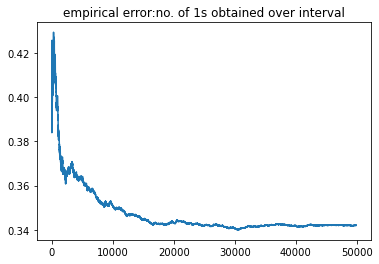

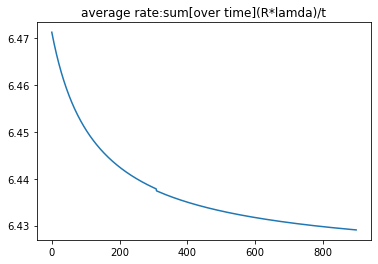

In [65]:
stat = 100
error_plot = 1.0 - np.copy(b)
for i in range(1,len(error_plot)):
    error_plot[i] += (error_plot[i-1]*(i-1))
    error_plot[i] =error_plot[i]/i
plt.plot(error_plot[stat:])
plt.title('empirical error:no. of 1s obtained over interval')
plt.show()
rate_plot = np.copy(avg_rate)
for i in range(1,len(rate_plot)):
    rate_plot[i] += (rate_plot[i-1]*(i-1))
    rate_plot[i] =rate_plot[i]/i
plt.plot(rate_plot[stat:])
plt.title('average rate:sum[over time](R*lamda)/t')
plt.show()

In [66]:
print(x0.flatten())
print(x[-1].flatten(),error_plot[-1],rate_plot[-1])
print(org_x,tol,dot(org_x,R))

[0.25 0.25 0.5  0.   0.  ]
[0.42263735 0.         0.         0.57736265 0.        ] 0.342066841336826 6.4290882414920425
[0.50100842 0.         0.         0.49899158 0.        ] 0.35 6.50100842330051


4.994333066171857


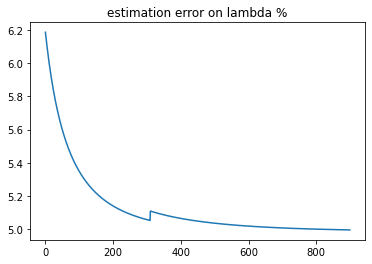

In [67]:
err = []
for i in range(len(x)):
    err.append(np.sqrt(np.sum(np.square(org_x-x[i].flatten()))/en)*100)
    err[i] += (err[i-1]*(i))
    err[i] = err[i]/(i+1)
print(err[-1])
plt.plot(err[stat:])
plt.title('estimation error on lambda %')
plt.show()

10.993864034570253


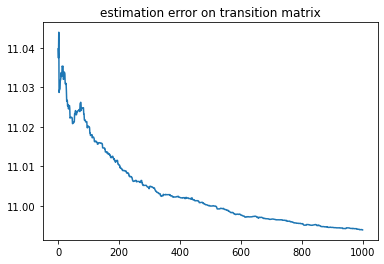

In [68]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(P-i))/s)*100)
print(err[-1])
plt.plot(err)
plt.title('estimation error on transition matrix')
plt.show()

[0.2528219  0.25315006 0.24741822 0.24660982]
[0.28025478 0.22321946 0.15894615 0.33757962]
7.692250377363348


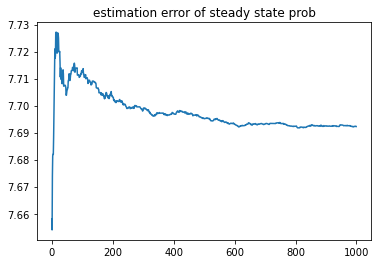

In [69]:
err = []; s = np.shape(P)[0]*np.shape(P)[1]
for i in p:
    err.append(np.sqrt(np.sum(np.square(steady_state_prob(P)-steady_state_prob(i)))/3)*100)
print(steady_state_prob(p[-1]))
print(steady_state_prob(P))
print(err[-1])
plt.plot(err)
plt.title('estimation error of steady state prob')
plt.show() 

In [57]:
# Rough

In [ ]:
(Ra*math.sqrt(en*math.log10((1+(t-1)*La*La/.1)/0.9))+math.sqrt(.1)*Sa)*linalg.norm(xopt) 

In [ ]:
alfa_c -> lamda error %
0.0 -> 0.7263980978187543
0.0001 -> 0.64
0.001 -> 0.17
0.005 -> 4